# OSM POIs

Points of Interests from OpenStreetMap data.

In [1]:
import requests
import json
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import os

from shapely.geometry import Point, LineString
from adjustText import adjust_text

overpass_url = "http://overpass-api.de/api/interpreter"


In [2]:
def geojsnify(a):
    returnable = {
        "type": "FeatureCollection",
        "features": []
    }
    for element in a:
        if element['type'] == 'way':
            coords = [(geom['lon'], geom['lat']) for geom in element['geometry']]
            line = LineString(coords)
            feature = {'type': 'Feature', 'geometry': line.__geo_interface__, 'properties': {'type': element['type']}}
            returnable["features"].append(feature)
        elif element['type'] == 'node':
            point = Point(element['lon'], element['lat'])
            feature = {'type': 'Feature', 'geometry': point.__geo_interface__, 'properties': {'type': element['type']}}
            returnable["features"].append(feature)
        elif element['type'] == 'LineString':
            coords = [(geom['lon'], geom['lat']) for geom in element['geometry']]
            line = LineString(coords)
            feature = {'type': 'Feature', 'geometry': line.__geo_interface__, 'properties': {'type': element['type']}}
            returnable["features"].append(feature)
    return returnable

# Cities

In [3]:

cities_query = """
[out:json];
area["ISO3166-1"="FI"][admin_level=2];
node[place~"city|town"](area);
out center;
"""

cities_response = requests.get(overpass_url, params={"data": cities_query})
cities_data = cities_response.json()

In [4]:
finland_query = """
[out:json];
rel[boundary=administrative][admin_level=2]["ISO3166-1"="FI"];
out geom;
"""

finland_response = requests.get(overpass_url, params={"data": finland_query})
finland_data = finland_response.json()
#print(finland_data)

In [5]:

finland_bounds = finland_data["elements"][0]["bounds"]
aspect_ratio = 1 + (finland_bounds['maxlat'] - finland_bounds['minlat']) / (finland_bounds['maxlon'] - finland_bounds['minlon'])
#print(aspect_ratio)



In [6]:
gdf_finland = gpd.read_file("data/wind/finland.geojson")
# fig, ax = plt.subplots(figsize=(10, 10 * aspect_ratio))
# gdf_finland.plot(ax=ax, color='blue')
# ax.set_aspect(aspect_ratio)
# plt.show()

In [7]:
#print(json.dumps(data, indent=2))
cities = [(element["tags"]["name"], int(re.sub(r'\D', '', str(element["tags"].get("population", 0)))), element["lat"], element["lon"]) for element in cities_data["elements"]]
cities = list(filter(lambda x: x[1] > 1000, cities))
#print(cities)
cities = sorted(cities, key = lambda x: -x[1])
#print(cities)

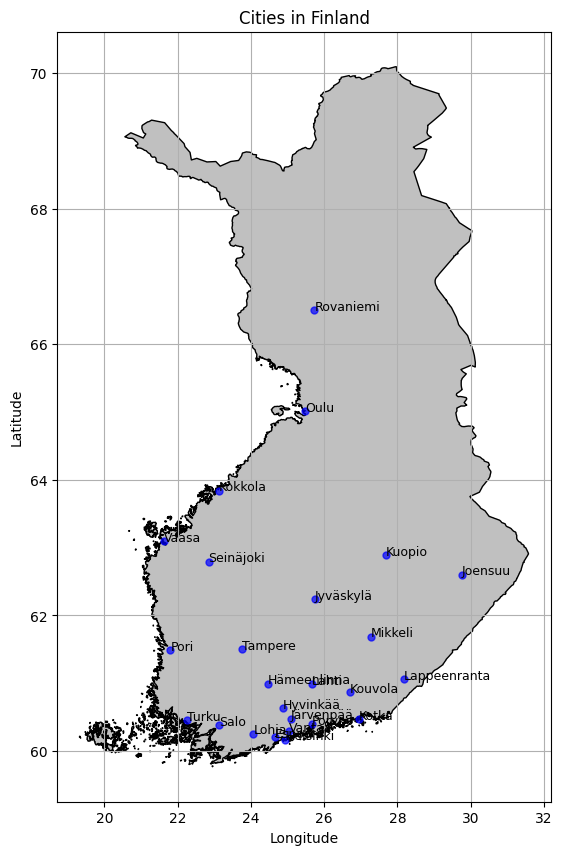

In [8]:
latitudes = [i[2] for i in cities]
longitudes = [i[3] for i in cities]
populations = [i[1] for i in cities]


fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')


#ax.scatter(longitudes, latitudes, alpha=0.5, color='blue')  # Adjust the color as needed

for i in cities[:25]:
    ax.plot(i[3], i[2], color='blue', marker='o', markersize=5, alpha=0.7)
    ax.text(i[3], i[2], i[0], fontsize=9)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Cities in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

# High voltage power lines in Finland



In [9]:

powerlines_query = """
[out:json];
area["ISO3166-1"="FI"][admin_level=2];
(
  way[power=line](area);
  way[power=cable](area);
);
out geom;
"""

powerlines_response = requests.get(overpass_url, params={"data": powerlines_query})
powerline_data = powerlines_response.json()
#print(powerline_data)

powerlines_geojson = geojsnify(powerline_data["elements"])

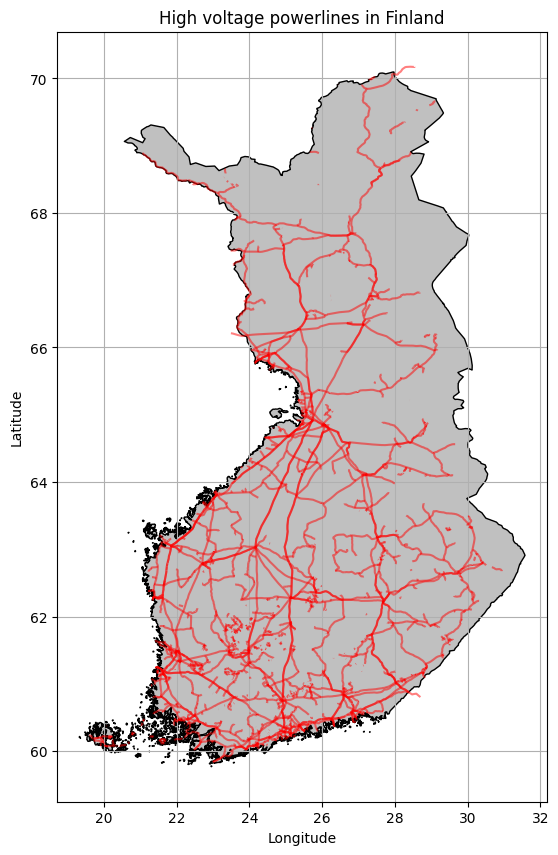

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')

powerline_gdp = gpd.GeoDataFrame.from_features(powerlines_geojson)
powerline_gdp.plot(ax=ax, color='red', alpha=0.5)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('High voltage powerlines in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

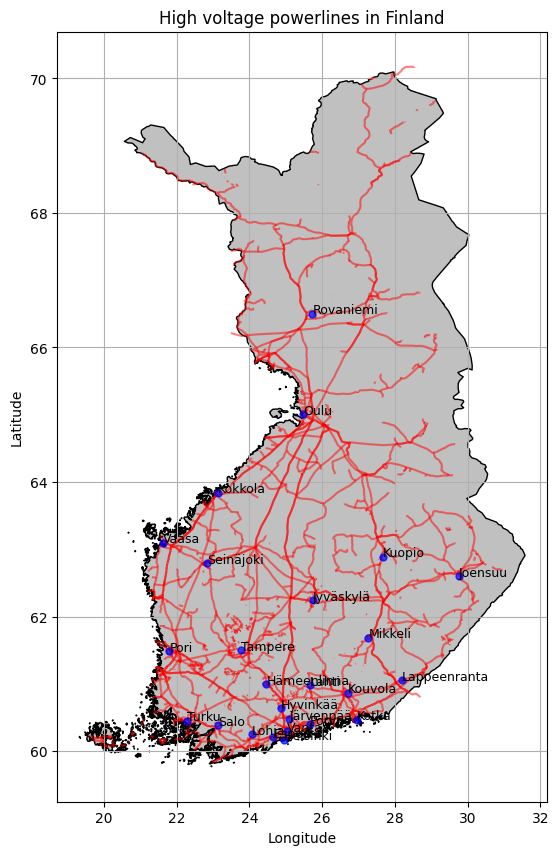

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')

powerline_gdp = gpd.GeoDataFrame.from_features(powerlines_geojson)
powerline_gdp.plot(ax=ax, color='red', alpha=0.5)  # Adjust color and transparency as needed

for i in cities[:25]:
    ax.plot(i[3], i[2], color='blue', marker='o', markersize=5, alpha=0.7)
    ax.text(i[3], i[2], i[0], fontsize=9)
    
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('High voltage powerlines in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

In [12]:
powerline_gdp.to_file('data/poi/powerline.geojson', driver="GeoJSON")

## Subsea cable locations

Not very detailed, probably not interesting.

In [13]:
subseacable_query = """
[out:json];
area["ISO3166-1"="FI"][admin_level=2];
(
  way["seamark:cable_submarine:category"=fibre_optic](area);
);
out geom;
"""

subseacable_response = requests.get(overpass_url, params={"data": subseacable_query})
subseacable_data = subseacable_response.json()
#print(subseacable_data)

subseacable_geojson = geojsnify(subseacable_data["elements"])

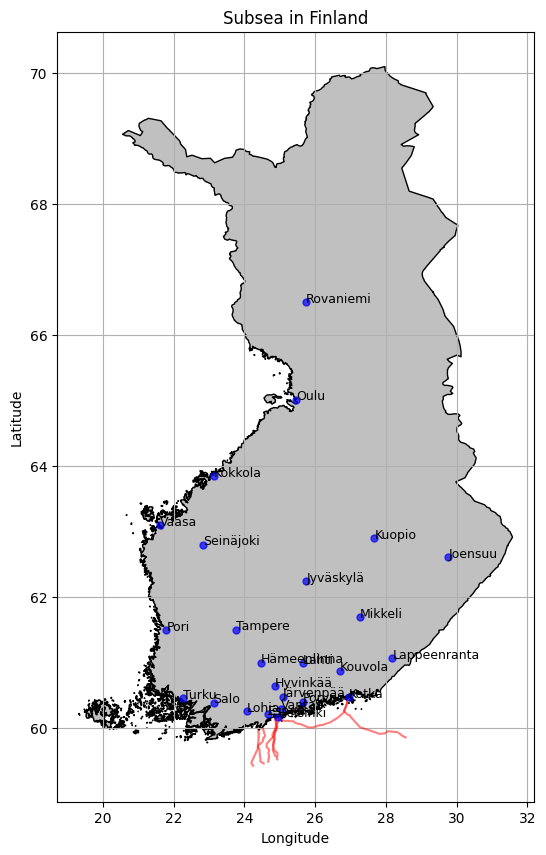

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')

subseacable_gdp = gpd.GeoDataFrame.from_features(subseacable_geojson)
subseacable_gdp.plot(ax=ax, color='red', alpha=0.5)

for i in cities[:25]:
    ax.plot(i[3], i[2], color='blue', marker='o', markersize=5, alpha=0.7)
    ax.text(i[3], i[2], i[0], fontsize=9)
    
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Subsea in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

In [15]:
subseacable_gdp.to_file('data/poi/subseacable.geojson', driver="GeoJSON")


# Conclusion

All atleast mildly useful data in one plot.

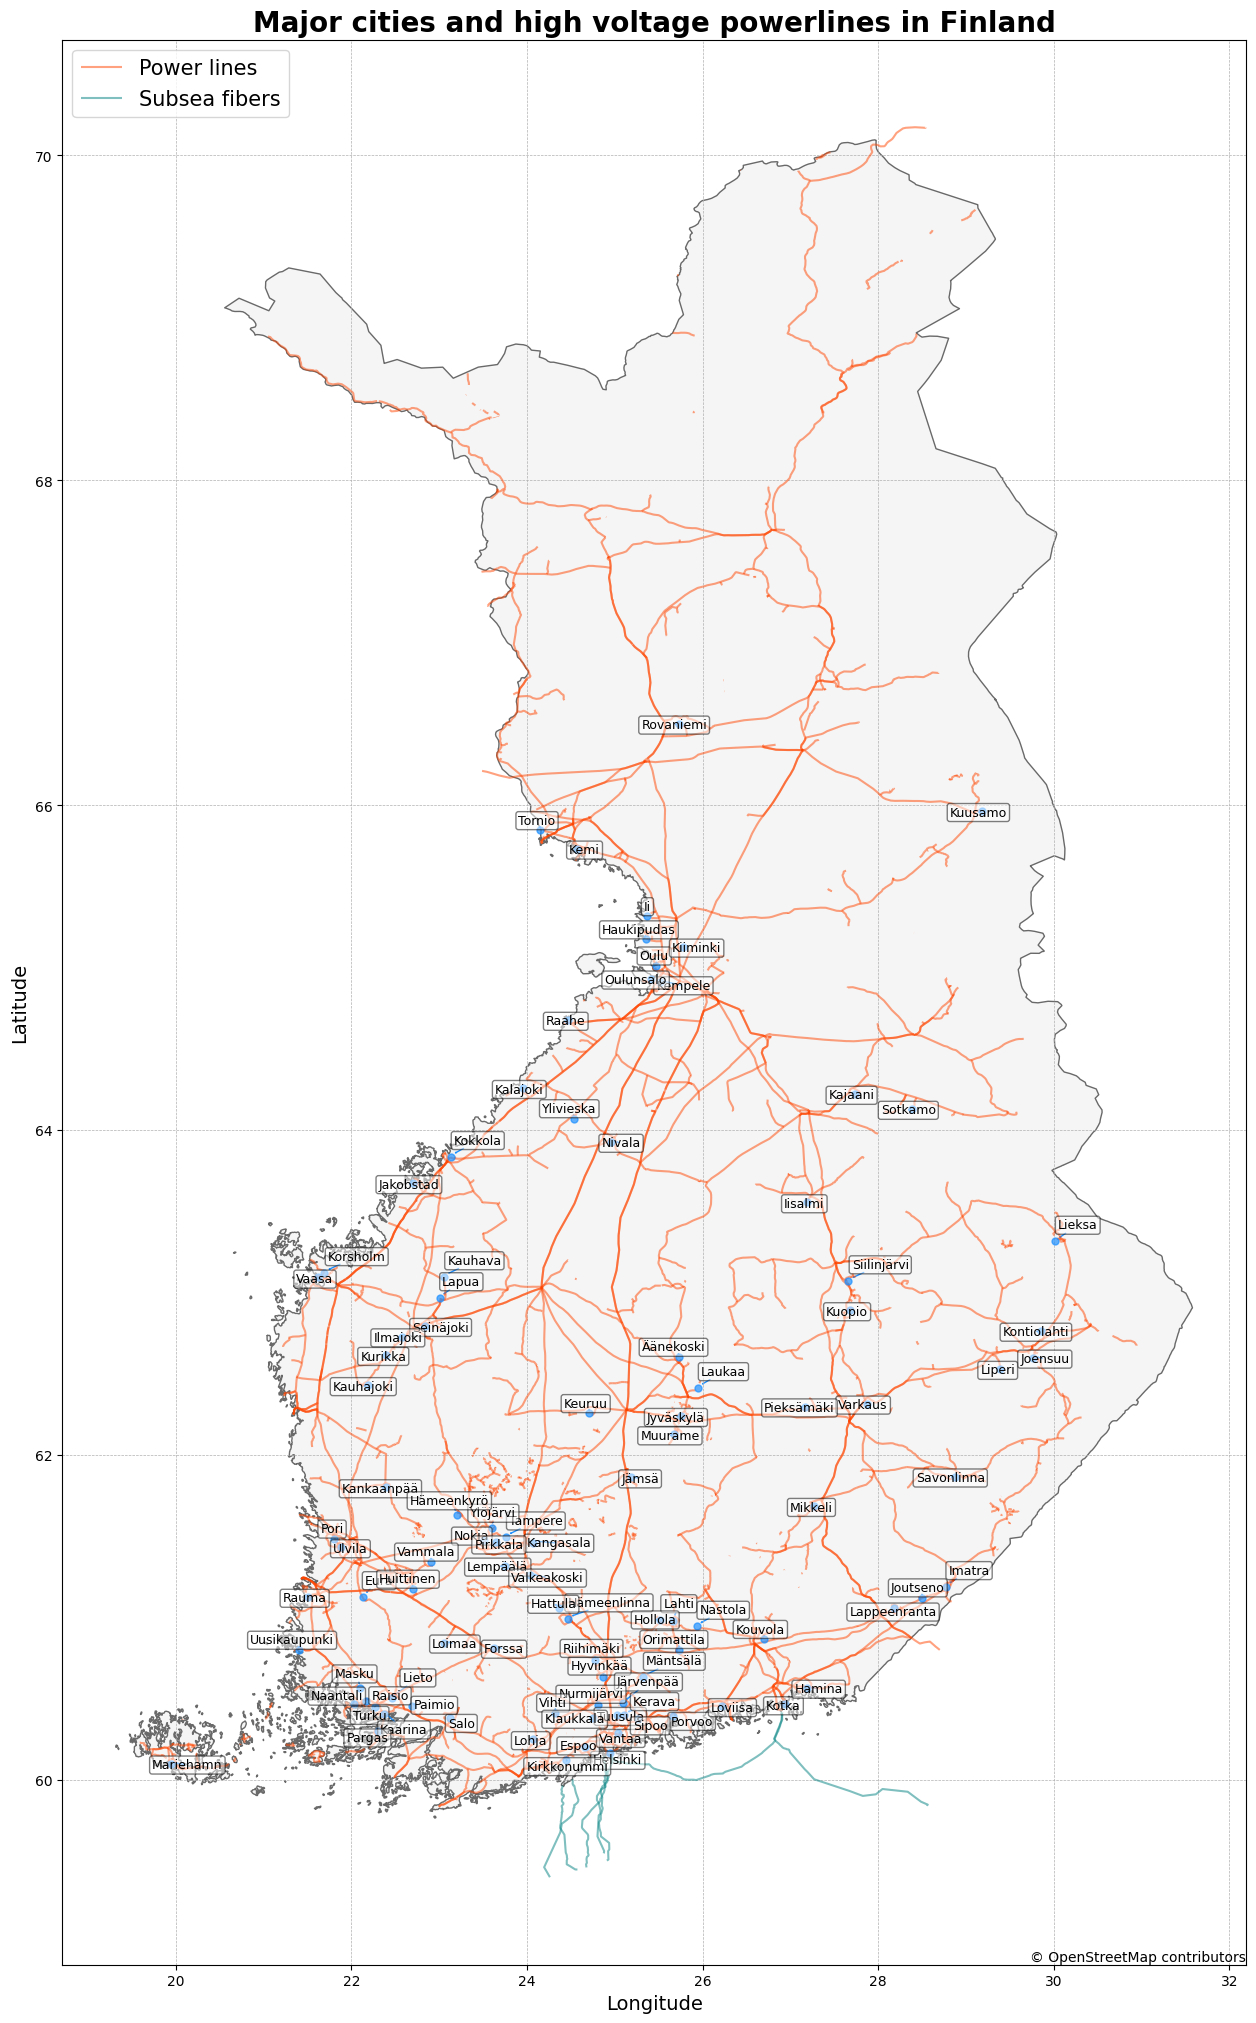

In [16]:
fig, ax = plt.subplots(figsize=(25, 25))
gdf_finland.plot(ax=ax, color='whitesmoke', edgecolor='dimgray')

powerline_gdp = gpd.GeoDataFrame.from_features(powerlines_geojson)
powerline_gdp.plot(ax=ax, color='orangered', alpha=0.5, label="Power lines")

subseacable_gdp = gpd.GeoDataFrame.from_features(subseacable_geojson)
subseacable_gdp.plot(ax=ax, color='teal', alpha=0.5, label="Subsea fibers")

texts = []
for i in cities[:100]:
    ax.plot(i[3], i[2], color='dodgerblue', marker='o', markersize=5, alpha=0.7)
    texts.append(ax.text(i[3] + 0.01, i[2] + 0.01, i[0], fontsize=9, 
                         ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.2')))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='dodgerblue'), force_text=(0.3, 0.3))

ax.set_title('Major cities and high voltage powerlines in Finland', fontsize=20, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_aspect(aspect_ratio)

ax.annotate('\xa9 OpenStreetMap contributors', xy=(1, 0),xycoords='axes fraction', fontsize=10, horizontalalignment='right', verticalalignment='bottom')
ax.legend(loc='upper left', fontsize=15)

plt.show()

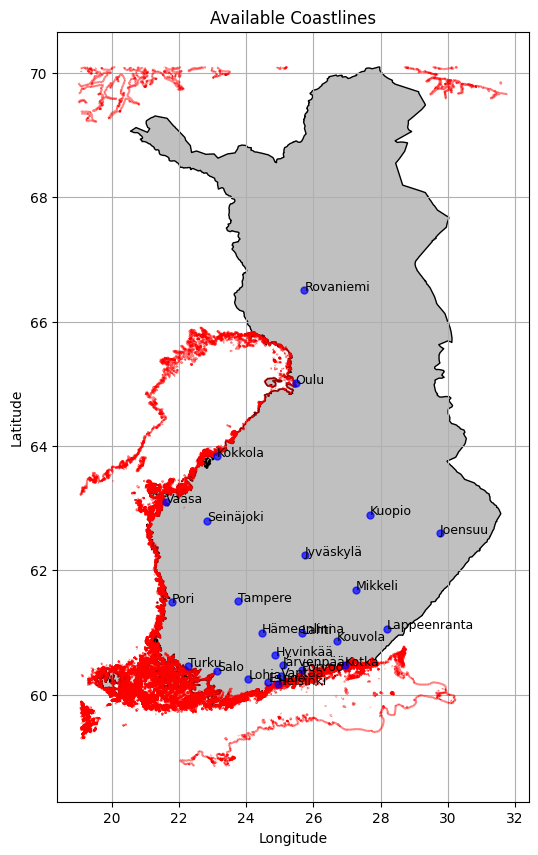

In [20]:
coastline_query = """
[out:json];
(
  nwr["natural"="coastline"](58.85, 19.09, 70.09, 31.58);
);
out geom;
"""
coastline_response = requests.get(overpass_url, params={"data": coastline_query})
coastline_data = coastline_response.json()
#print(coastline_data)

coastline_geojson = geojsnify(coastline_data["elements"])
fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')

coastline_gdp = gpd.GeoDataFrame.from_features(coastline_geojson, crs='EPSG:4326').simplify(0.01)
coastline_gdp.plot(ax=ax, color='red', alpha=0.5)

for i in cities[:25]:
    ax.plot(i[3], i[2], color='blue', marker='o', markersize=5, alpha=0.7)
    ax.text(i[3], i[2], i[0], fontsize=9)
    
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Available Coastlines')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()



In [21]:
coastline_gdp.to_file('data/poi/coastline.geojson', driver="GeoJSON")